In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'chestmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
from torch.utils.data import DataLoader


# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load datasets (already split)
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)  # Use 'val' instead of splitting
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 78468
Validation samples: 11219
Test samples: 22433


In [6]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 78468
    Root location: /home/oussama/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 11219


In [7]:
# visualization

train_dataset.montage(length=1)

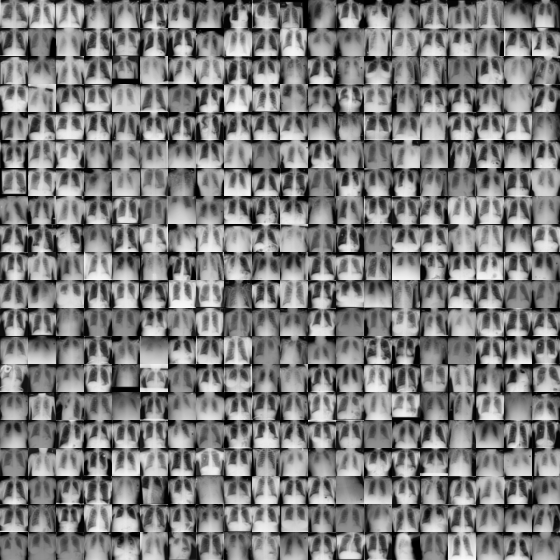

In [8]:
# montage

train_dataset.montage(length=20)

In [9]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


/home/oussama/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [20]:
class M8(torch.nn.Module):
    def __init__(self, output=9):
        super(M8, self).__init__()
        # Layer 1
        self.Conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.ReLU1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 2
        self.Conv2 = torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.ReLU2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 3
        self.Conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.ReLU3 = nn.ReLU()
        self.AvgPool3 = torch.nn.AvgPool2d(kernel_size = 3)
        self.Flatten = nn.ReLU()
        self.FC1 = torch.nn.Linear(1*1*128, output)


    def forward(self, x):
        out = self.Conv1(x)
        out = self.ReLU1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.ReLU2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.ReLU3(out)
        out = self.AvgPool3(out)
        out = self.Flatten(out)
        out = out.view(out.shape[0], -1)  # Fix flattening
        out = self.FC1(out)
        return out
    
model = M8(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [10]:
class Square(torch.nn.Module):
    def forward(self, x):
        return x**2

class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [65]:
class M2(torch.nn.Module):
    def __init__(self, output=9):
        super(M2, self).__init__()
        self.Conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=0)
        self.Square1 = Square()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size=2)
        self.Conv2 = torch.nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5, stride=1, padding=0)
        self.Square2 = Square()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size=2)
        self.Flatten = Flatten()
        self.FC1 = torch.nn.Linear(192, output)

    def forward(self, x):
        out = self.Conv1(x)
        out = self.Square1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.Square2(out)
        out = self.AvgPool2(out)
        out = self.Flatten(out)
        out = self.FC1(out)
        return out
    
model = M2(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [21]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [22]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/10] Training...


100%|██████████| 614/614 [00:19<00:00, 32.12it/s]



Summary: Train Loss: 0.4063, Train Acc: 94.86%, Validation Loss: 0.0923, Validation Acc: 94.92%

Epoch [2/10] Training...


 36%|███▋      | 224/614 [00:06<00:12, 32.27it/s]


KeyboardInterrupt: 

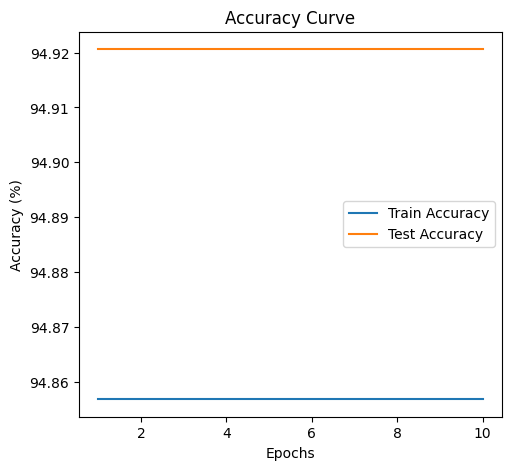

In [59]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [68]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 0.1834, Accuracy: 94.74%


In [69]:
# Save the trained model
MODEL_PATH = "chestxray_model1.pth"
torch.save(model, MODEL_PATH)

print(f"Model saved successfully as {MODEL_PATH}!")

Model saved successfully as chestxray_model1.pth!


In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x

        # Main path
        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu(out)
        
        return out


In [18]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        # output = self.conv2(output)
        # output = self.relu2(output)
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)